In [1]:
### Title: PLOT AND ANALYZE DESEQ2 results - Figure S3 A and B
### Date: 2025/01/21
### Input: results.csv file obtained from DESEQ2.R script, gtf file used for mapping/index building with STAR
###        significantly_altered_cassette_exons.csv from script 1
### output: volcano plot, gene_name assignment based on gtf, venn diagram for overlap with whippet results  

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_venn import venn2
import matplotlib.pyplot as plt


In [9]:
# Load the DESeq2 results
data = pd.read_csv('deseq2_results.csv')
results = "/path/to/store/results/"
figures = "/path/to/store/figures/"
files = "/path/to/annotation/files/"

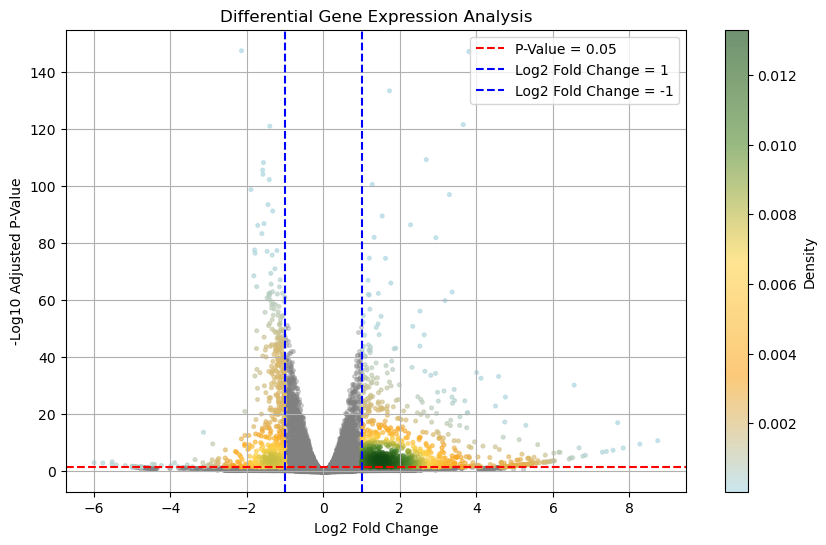

In [12]:
# Compute -log10 adjusted p-value
data['-log10_padj'] = -np.log10(data['padj'])

# Define significance conditions
upregulated_condition = (data['log2FoldChange'] >= 1) & (data['padj'] < 0.05)
downregulated_condition = (data['log2FoldChange'] <= -1) & (data['padj'] < 0.05)

# Subset highlighted points
highlighted = data.loc[upregulated_condition | downregulated_condition]
xy_highlighted = np.vstack([highlighted['log2FoldChange'], highlighted['-log10_padj']])
density_highlighted = gaussian_kde(xy_highlighted)(xy_highlighted)

# Normalize the density
norm = Normalize(vmin=density_highlighted.min(), vmax=density_highlighted.max())

# Sort by density
sorted_indices = density_highlighted.argsort()
highlighted_sorted = highlighted.iloc[sorted_indices]
density_sorted = density_highlighted[sorted_indices]

# Create custom colormap
custom_colors = ["#A8D5E2", "#F9A620", "#FFD449", "#548C2F", "#104911"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

# Plot
plt.figure(figsize=(10, 6))

# Plot non-significant points
plt.scatter(data.loc[~(upregulated_condition | downregulated_condition), 'log2FoldChange'],
            data.loc[~(upregulated_condition | downregulated_condition), '-log10_padj'],
            s=7, alpha=0.3, color='gray')

# Plot highlighted points with density coloring and normalized color range
sc = plt.scatter(highlighted_sorted['log2FoldChange'], highlighted_sorted['-log10_padj'],
                 c=density_sorted, s=7, alpha=0.6, cmap=custom_cmap, norm=norm)

# Add colorbar using the same normalization
cbar = plt.colorbar(sc)
cbar.set_label('Density')

# Annotations and lines
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-Value')
plt.title('Differential Gene Expression Analysis')
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='P-Value = 0.05')
plt.axvline(1, color='blue', linestyle='--', label='Log2 Fold Change = 1')
plt.axvline(-1, color='blue', linestyle='--', label='Log2 Fold Change = -1')
plt.grid(True)
plt.legend()

# Save and show
plt.savefig(figures + 'gene_expression_eif4a3_smash_vs_ctr.png')
plt.savefig(figures + 'gene_expression_eif4a3_smash_kd_vs_ctr.pdf')

plt.show()


In [23]:
# Define significance thresholds
log2fc_threshold = 1 
padj_threshold = 0.05

# Apply conditions for significance
significant_genes = data[(abs(data['log2FoldChange']) >= log2fc_threshold) & 
                            (data['padj'] < padj_threshold)]

# Count significant genes
num_significant_genes = len(significant_genes)

print(f"Number of significantly altered genes: {num_significant_genes}")

# Optional: Count upregulated and downregulated genes
upregulated_genes = significant_genes[significant_genes['log2FoldChange'] > 0]
downregulated_genes = significant_genes[significant_genes['log2FoldChange'] < 0]

print(f"Number of upregulated genes: {len(upregulated_genes)}")
print(f"Number of downregulated genes: {len(downregulated_genes)}")


Number of significantly altered genes: 1828
Number of upregulated genes: 1139
Number of downregulated genes: 689


In [24]:
### --- ASSIGN GENE NAMES BASED ON TRANSCRIPT ID ----
gtf_file = files+'gencode.v44.basic.annotation.gtf'

In [28]:
import pandas as pd

# Function to parse the GTF file and extract gene_id and gene_name
def parse_gtf(gtf_file):
    # Load the GTF file
    gtf_df = pd.read_csv(
        gtf_file,
        sep='\t',
        comment='#',
        header=None,
        names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
    )
    
    # Extract relevant fields from the attributes column
    gtf_df['gene_id'] = gtf_df['attribute'].str.extract(r'gene_id "([^"]+)"')
    gtf_df['gene_name'] = gtf_df['attribute'].str.extract(r'gene_name "([^"]+)"')
    
    # Keep only gene_id and gene_name, and drop duplicates
    gtf_df = gtf_df[['gene_id', 'gene_name']].drop_duplicates()
    
    return gtf_df

# Function to assign gene names to DESeq2 results based on gene IDs
def assign_gene_names(deseq_file, gtf_file, output_file):
    # Load DESeq2 results
    deseq_df = pd.read_csv(deseq_file)
    
    # Parse the GTF file
    gtf_df = parse_gtf(gtf_file)
    
    # Merge DESeq2 results with gene names based on gene IDs
    merged_df = deseq_df.merge(gtf_df, left_on='Unnamed: 0', right_on='gene_id', how='left')
    
    # Ensure no additional rows are created during the merge
    assert len(deseq_df) == len(merged_df), "Merge resulted in additional rows! Check for duplicates."
    
    # Save the resulting DataFrame to a file
    merged_df.to_csv(output_file, index=False)
    print(f"Gene names assigned and saved to {output_file}")

# File paths 
deseq_file = 'deseq2_results.csv'
output_file = results + 'deseq2_with_gene_names.csv' 

# Run the function
assign_gene_names(deseq_file, gtf_file, output_file)


Gene names assigned and saved to /Users/alexandrabergfort/Dropbox/NeugebauerLab/Bioinformatics/SRS_EIF4A3smash_April2024/Jan2025_final_analysis/results/deseq2_with_gene_names.csv


In [29]:

# Load the output file with gene names
output_file = "deseq2_with_gene_names.csv"  
data = pd.read_csv(output_file)

# Define significance criteria
padj_threshold = 0.05  
log2fc_threshold = 1   

# Filter significant entries
significant_df = data[
    (data['padj'] < padj_threshold) & 
    (abs(data['log2FoldChange']) >= log2fc_threshold)
]

# Save the filtered DataFrame to a new CSV file
filtered_output_file = results + "kd_vs_ctr_deseq2_significant_genes_l2fc_1_padj_0.05.csv"
significant_df.to_csv(filtered_output_file, index=False)

print(f"Filtered significant entries saved to {filtered_output_file}")


Filtered significant entries saved to /Users/alexandrabergfort/Dropbox/NeugebauerLab/Bioinformatics/SRS_EIF4A3smash_April2024/Jan2025_final_analysis/results/20250121_kd_vs_ctr_deseq2_significant_genes_l2fc_1_padj_0.05.csv


In [31]:
whippet= pd.read_csv(results+'sig_whip_CE_prob0.9_dPSI0.1.csv')

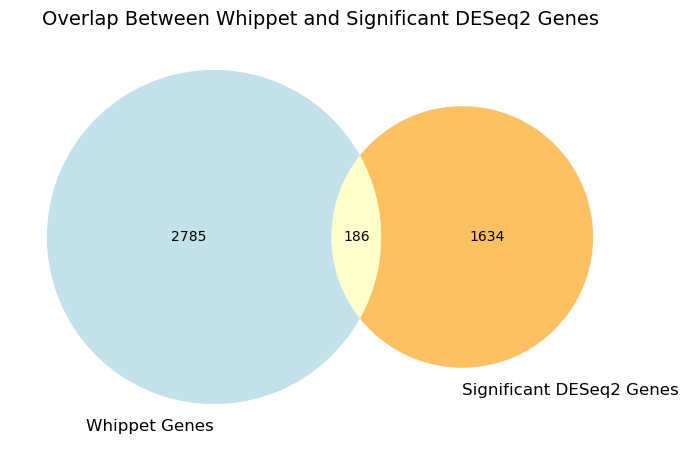

Unique genes in Whippet: 2971
Unique genes in Significant DESeq2: 1820
Overlap: 186


In [47]:
# Extract unique gene names from both DataFrames
whippet_genes = set(whippet['gene_name'].dropna().unique())
significant_genes = set(significant_df['gene_name'].dropna().unique())

# Define your custom color palette
custom_colors = ["#A8D5E2", "#F9A620", "#FFD449", "#548C2F", "#104911"]
circle_colors = [custom_colors[0], custom_colors[1]]  # Choose two colors for the circles

# Create the Venn diagram
plt.figure(figsize=(8, 6))
venn = venn2(
    [whippet_genes, significant_genes],
    set_labels=("Whippet Genes", "Significant DESeq2 Genes"),
    set_colors=circle_colors,  # Apply custom colors
    alpha=0.7  # Adjust transparency
)

# Customize plot
plt.title("Overlap Between Whippet and Significant DESeq2 Genes", fontsize=14)

plt.savefig(figures+'20250121_venn2_whip_sig_deseq2_sig.png')
plt.savefig(figures+'20250121_venn2_whip_sig_deseq2_sig.pdf')
plt.show()

# Optional: Print counts
print(f"Unique genes in Whippet: {len(whippet_genes)}")
print(f"Unique genes in Significant DESeq2: {len(significant_genes)}")
print(f"Overlap: {len(whippet_genes & significant_genes)}")


In [46]:
## DETERMINE HOW MANY GENES ARE EXPRESSED IN THE SAMPLES (MEAN)

# Load DESeq2 results
deseq_df = pd.read_csv(deseq_file)

# Define a threshold for expression
expression_threshold = 10  # Minimum baseMean value to consider a gene as expressed

# Determine expressed genes
expressed_genes = deseq_df[deseq_df['baseMean'] > expression_threshold]

# Count the number of expressed genes
num_expressed_genes = len(expressed_genes)

print(f"Number of expressed genes: {num_expressed_genes}")

# # Optional: Save expressed genes to a new CSV file
# expressed_genes_file = "expressed_genes.csv"
# expressed_genes.to_csv(expressed_genes_file, index=False)


Number of expressed genes: 18888


In [42]:
blocks=pd.read_csv('block_exons_ddPSImax0.2_adjacent.moreSKIPPED.csv')

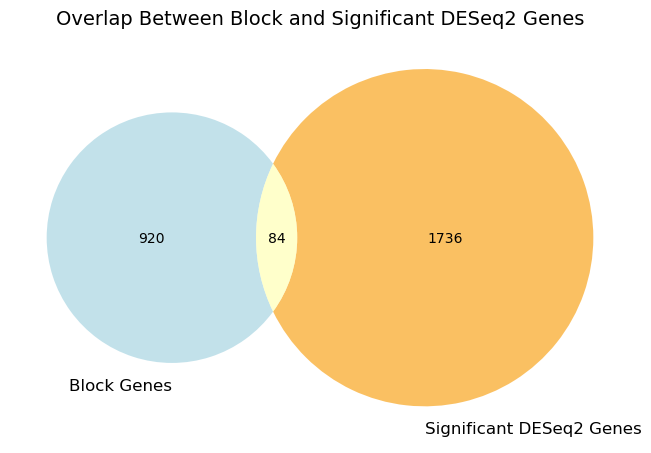

Unique genes in Blocks: 1004
Unique genes in Significant DESeq2: 1820
Overlap: 84


In [48]:
# Extract unique gene names from both DataFrames
block_genes = set(blocks['gene_name'].dropna().unique())
significant_genes = set(significant_df['gene_name'].dropna().unique())

# Define your custom color palette
custom_colors = ["#A8D5E2", "#F9A620", "#FFD449", "#548C2F", "#104911"]
circle_colors = [custom_colors[0], custom_colors[1]]  # Choose two colors for the circles

# Create the Venn diagram
plt.figure(figsize=(8, 6))
venn = venn2(
    [block_genes, significant_genes],
    set_labels=("Block Genes", "Significant DESeq2 Genes"),
    set_colors=circle_colors,  # Apply custom colors
    alpha=0.7  # Adjust transparency
)

# Customize plot
plt.title("Overlap Between Block and Significant DESeq2 Genes", fontsize=14)

plt.savefig(figures+'20250122_venn2_block_genes_sig_deseq2_sig.png')
plt.savefig(figures+'20250122_venn2_block_genes_sig_deseq2_sig.pdf')
plt.show()

# Optional: Print counts
print(f"Unique genes in Blocks: {len(block_genes)}")
print(f"Unique genes in Significant DESeq2: {len(significant_genes)}")
print(f"Overlap: {len(block_genes & significant_genes)}")
